In [132]:
from read_alignment import readAlignment
import helperFxns_new as kim_helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
import seaborn as sns
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
import statistics
from itertools import chain
from scipy.stats import permutation_test

In [35]:
mi_mpnn = np.load('data/derivatives/mi_lxl_mpnn.npy')
mi_nat = np.load('data/derivatives/mi_lxl_natural.npy')
cov_mpnn = np.load('data/derivatives/mpnn_cov.npy')
cov_nat = np.load('data/derivatives/nat_cov.npy')

In [142]:
# Example covariance matrix (positions x positions)
cov_matrix = np.random.rand(10, 10)  # Replace with your covariance matrix
np.fill_diagonal(cov_matrix, 0)  # Remove self-loops

# covariance matrix
mpnn_cov = cov_mpnn.copy()
nat_cov = cov_nat.copy()

sample_mpnn = mpnn_cov[:10, :10]
sample_nat = nat_cov[:10, :10]

def lxl_graph(matrix, threshold=0):

    if threshold==0: 
        threshold = np.mean(matrix) + np.std(matrix)
    # Thresholding approach
    else: 
        threshold = threshold # if a threshold is passed in
    G = nx.Graph()
    
    # Add edges based on threshold
    num_positions = matrix.shape[0]
    for i in range(num_positions):
        for j in range(i + 1, num_positions):  # Avoid duplicate edges
            if abs(matrix[i, j]) > threshold:
                G.add_edge(i, j, weight=matrix[i, j])
    return G, threshold

def plot_graph(G):
    # Visualize
    pos = nx.spring_layout(G)
    edges = nx.get_edge_attributes(G, 'weight')
    nx.draw(G, pos, with_labels=True, node_size=200, edge_color='gray')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edges)

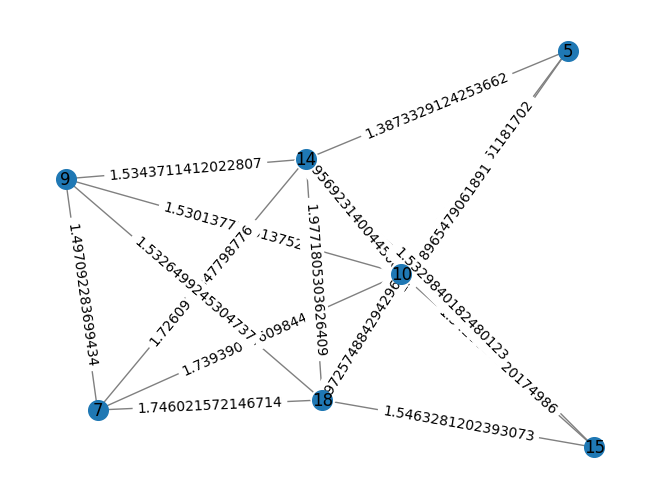

In [143]:
plot_graph(lxl_graph(nat_cov[:20])[0])

In [123]:
# USE THIS FUNCTION for avg path length
def avg_path_length(G):
# This includes the isolated node!
  path_lengths = (x.values() for x in dict(nx.shortest_path_length(G)).values())
  return statistics.mean(chain.from_iterable(path_lengths))

def edge_density(G):
  return G.number_of_edges()/(G.number_of_nodes()*(G.number_of_nodes()-1)/2)

def degrees(G):
  degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)

  vals = []
  for node, val in degrees:
    vals.append(val)

  return np.mean(vals)

G, t = lxl_graph(nat_cov)
print("threshold", t)
print("number of nodes", G.number_of_nodes())
print("number of edges", G.number_of_edges())
print("avg degrees", degrees(G))
print("avg path length", avg_path_length(G))
print("avg clustering", nx.average_clustering(G))
print("edge density", edge_density(G))

threshold 1.601244756955517
number of nodes 243
number of edges 21646
avg degrees 178.15637860082305
avg path length 1.2586834662737727
avg clustering 0.9078344621348631
edge density 0.7361833826480291


In [127]:
G, t = lxl_graph(cov_mpnn)
print("threshold", t)
print("number of nodes", G.number_of_nodes())
print("number of edges", G.number_of_edges())
print("avg degrees", degrees(G))
print("avg path length", avg_path_length(G))
print("avg clustering", nx.average_clustering(G))
print("edge density", edge_density(G))

threshold 0.20573435215691782
number of nodes 243
number of edges 22909
avg degrees 188.5514403292181
avg path length 1.2158376941184441
avg clustering 0.9053452708508192
edge density 0.7791381831785872


In [125]:
G, t = lxl_graph(mi_nat)
print("threshold", t)
print("number of nodes", G.number_of_nodes())
print("number of edges", G.number_of_edges())
print("avg degrees", degrees(G))
print("avg path length", avg_path_length(G))
print("avg clustering", nx.average_clustering(G))
print("edge density", edge_density(G))

threshold 0.11212596261503438
number of nodes 443
number of edges 13801
avg degrees 62.306997742663654
avg path length 1.85514321092082
avg clustering 0.14414349388327155
edge density 0.1409660582413205


In [126]:
G, t = lxl_graph(mi_mpnn)
print("threshold", t)
print("number of nodes", G.number_of_nodes())
print("number of edges", G.number_of_edges())
print("avg degrees", degrees(G))
print("avg path length", avg_path_length(G))
print("avg clustering", nx.average_clustering(G))
print("edge density", edge_density(G))

threshold 0.11094262446002681
number of nodes 443
number of edges 13947
avg degrees 62.966139954853276
avg path length 1.8534311002858612
avg clustering 0.14283228663069633
edge density 0.14245733021460016


In [41]:
def get_edge_weights(G):
    weights = []
    edges = nx.get_edge_attributes(G, 'weight')
    for val in edges.values():
        weights.append(val)
    return weights 

In [110]:
def degree_histogram(G, G_2=0, G_2_color='blue', title="Degree Histogram"):
    degrees_1 = [G.degree(n) for n in G.nodes()]
    if G_2 != 0:
        degrees_2 = [G_2.degree(n) for n in G_2.nodes()]
        plt.hist(degrees_2,bins=100,align='left', rwidth=0.8, color=G_2_color, alpha=0.7, label='mpnn')
    plt.hist(degrees_1,bins=100,align='left', rwidth=0.8, color='purple', alpha=0.7, label='natural')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    plt.legend()
    plt.title(title)
    plt.show()

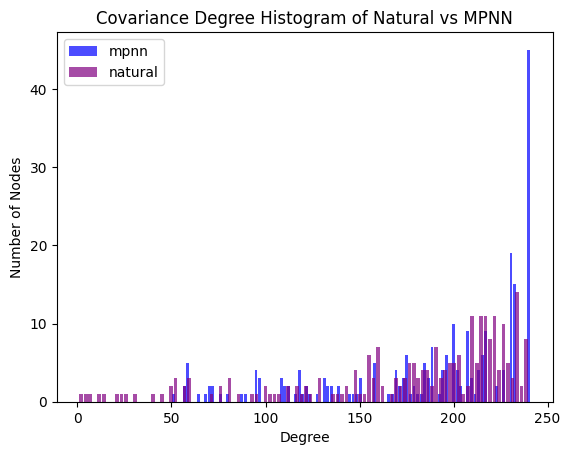

In [111]:
degree_histogram(lxl_graph(nat_cov)[0], lxl_graph(mpnn_cov)[0], title="Covariance Degree Histogram of Natural vs MPNN")

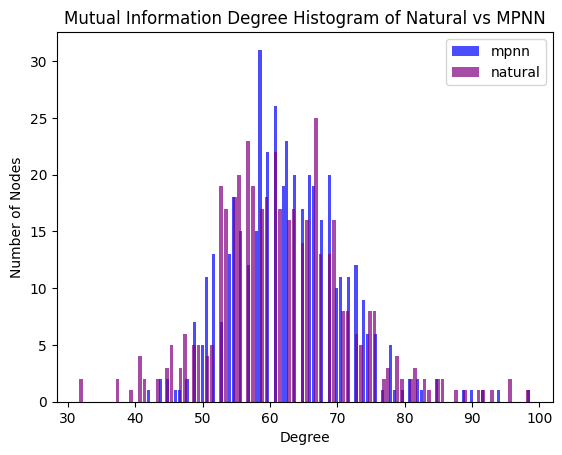

In [112]:
degree_histogram(lxl_graph(mi_nat)[0], lxl_graph(mi_mpnn)[0], title="Mutual Information Degree Histogram of Natural vs MPNN")

In [ ]:
G_nat = lxl_graph(nat_cov)[0]
G_mpnn = lxl_graph(mpnn_cov)[0]

degrees_nat = [G_nat.degree(n) for n in G_nat.nodes()]
degrees_mpnn = [G_mpnn.degree(n) for n in G_mpnn.nodes()]

# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)

# Perform the permutation test
result = permutation_test((degrees_nat, degrees_mpnn), test_statistic, n_resamples=10000, alternative='two-sided')

# Output the results
print("P-value:", result.pvalue)
print(test_statistic(degrees_nat, degrees_mpnn))

P-value: 0.041195880411958805
-10.395061728395063


In [135]:
G_nat = lxl_graph(mi_nat)[0]
G_mpnn = lxl_graph(mi_mpnn)[0]

degrees_nat = [G_nat.degree(n) for n in G_nat.nodes()]
degrees_mpnn = [G_mpnn.degree(n) for n in G_mpnn.nodes()]

# Define the test statistic (e.g., difference of means)
def test_statistic(x, y):
    return np.mean(x) - np.mean(y)

# Perform the permutation test
result = permutation_test((degrees_nat, degrees_mpnn), test_statistic, n_resamples=10000, alternative='two-sided')

# Output the results
print("P-value:", result.pvalue)
print(test_statistic(degrees_nat, degrees_mpnn))

P-value: 0.27777222277772223
-0.6591422121896215
